<a href="https://colab.research.google.com/github/germanjke/Deep_Learning_School_MIPT/blob/master/nlp_homeworks/homework_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 1.3MB 12.7MB/s 
     |████████████████████████████████| 153kB 53.2MB/s 
     |████████████████████████████████| 2.9MB 52.0MB/s 
     |████████████████████████████████| 890kB 48.2MB/s 
     |████████████████████████████████| 1.1MB 47.2MB/s 
     |████████████████████████████████| 245kB 52.0MB/s 
     |████████████████████████████████| 17.7MB 241kB/s 
ERROR: transformers 3.5.1 has requirement tokenizers==0.9.3, but you'll have tokenizers 0.9.4 which is incompatible.


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [5]:
emotion_dataset

DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)})

In [6]:
emotion_dataset["train"]

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [7]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [8]:
emotion_dataset["train"]["label"][0]

'sadness'

In [9]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [11]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [12]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [15]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [16]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [17]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        tokenizer_output = self.tokenizer.encode_plus(text, max_length=128, padding="max_length", return_tensors="pt")
        target = self.label2num[label]

        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [18]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [19]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [20]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [21]:
lr = 3e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [22]:
tokens =train_dataset[0]['input_ids'].to(device)  # Получи токены из датасета
mask = train_dataset[0]['mask'].to(device) # Получи маску из датасета

model_0(tokens,attention_mask=mask) # Посмотри на аутпут

(tensor([[-0.3805, -0.8551,  0.3589, -0.1316,  0.4947, -0.0602,  0.6215,  0.7607]],
        device='cuda:0', grad_fn=<IndexBackward>),
 (tensor([[[[[-9.8622e-01, -1.6938e-02,  2.2051e-01,  ...,  1.7773e-01,
               5.5409e-01,  6.7080e-01],
             [-3.0123e-01,  1.5309e-01,  1.4978e+00,  ...,  6.7761e-01,
              -6.4449e-01, -4.6608e-01],
             [ 5.5801e-01, -2.0051e-01, -7.1882e-01,  ..., -8.3211e-01,
              -2.4887e-01,  7.1658e-01],
             ...,
             [ 1.3359e-01, -1.1834e+00,  2.8187e-01,  ...,  3.6195e-01,
               5.9068e-01, -4.1977e-01],
             [ 1.3883e+00, -1.6775e+00,  1.5277e-01,  ...,  4.2686e-01,
               8.4841e-02, -3.1004e-01],
             [-6.8943e-01, -8.0220e-01,  2.5541e-01,  ...,  8.1785e-01,
              -4.9168e-01,  3.7916e-01]],
  
            [[ 6.8899e-01, -2.4367e-01, -2.2258e-01,  ..., -1.5905e-01,
              -1.4042e-01,  5.2862e-02],
             [ 4.6216e-01,  7.8178e-01,  9.2596e-01,

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [23]:
from tqdm.notebook import tqdm


def accuracy_counter(tensor, target):
    sm = torch.softmax(tensor, dim=1).argmax(dim=1)
    cor = (sm == target)
    acc = cor.sum().float() / float(len(target))
    return acc

num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
        train_loss += criterion(preds[1],target)
        loss = criterion(preds[1],target)
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].squeeze(1).to(device)
            mask  = batch['mask'].squeeze(1).to(device)
            preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
            valid_loss += criterion(preds[1], target)
            valid_acc += accuracy_counter(preds[1],target).item()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
      target = batch['target'].to(device)
      input_ids = batch['input_ids'].squeeze(1).to(device)
      mask  = batch['mask'].squeeze(1).to(device)
      preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
      test_acc += accuracy_counter(preds[1],target).item()
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.3134115934371948,Valid Loss: 0.4405132532119751,Valid Acc: 0.861328125



Train Loss: 0.2790012061595917,Valid Loss: 0.3145665228366852,Valid Acc: 0.8974609375



Train Loss: 0.1721358597278595,Valid Loss: 0.38378840684890747,Valid Acc: 0.89501953125



Train Loss: 0.13063548505306244,Valid Loss: 0.40925443172454834,Valid Acc: 0.88037109375



Train Loss: 0.1134052574634552,Valid Loss: 0.3834250867366791,Valid Acc: 0.896484375



Train Loss: 0.0966506153345108,Valid Loss: 0.414427250623703,Valid Acc: 0.87548828125



Train Loss: 0.08171598613262177,Valid Loss: 0.4239310920238495,Valid Acc: 0.89306640625



Train Loss: 0.06884298473596573,Valid Loss: 0.4166443347930908,Valid Acc: 0.89306640625



Train Loss: 0.05447833240032196,Valid Loss: 0.4127667248249054,Valid Acc: 0.90380859375



Train Loss: 0.05154697969555855,Valid Loss: 0.4721834659576416,Valid Acc: 0.88916015625
Test Acc: 0.88818359375


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [29]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [30]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [47]:
text = emotion_dataset['train']['text'][35] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [48]:
# text = 'i love mipt but sometimes i dont like mipt'
# tokens = tokenizer.tokenize(text)

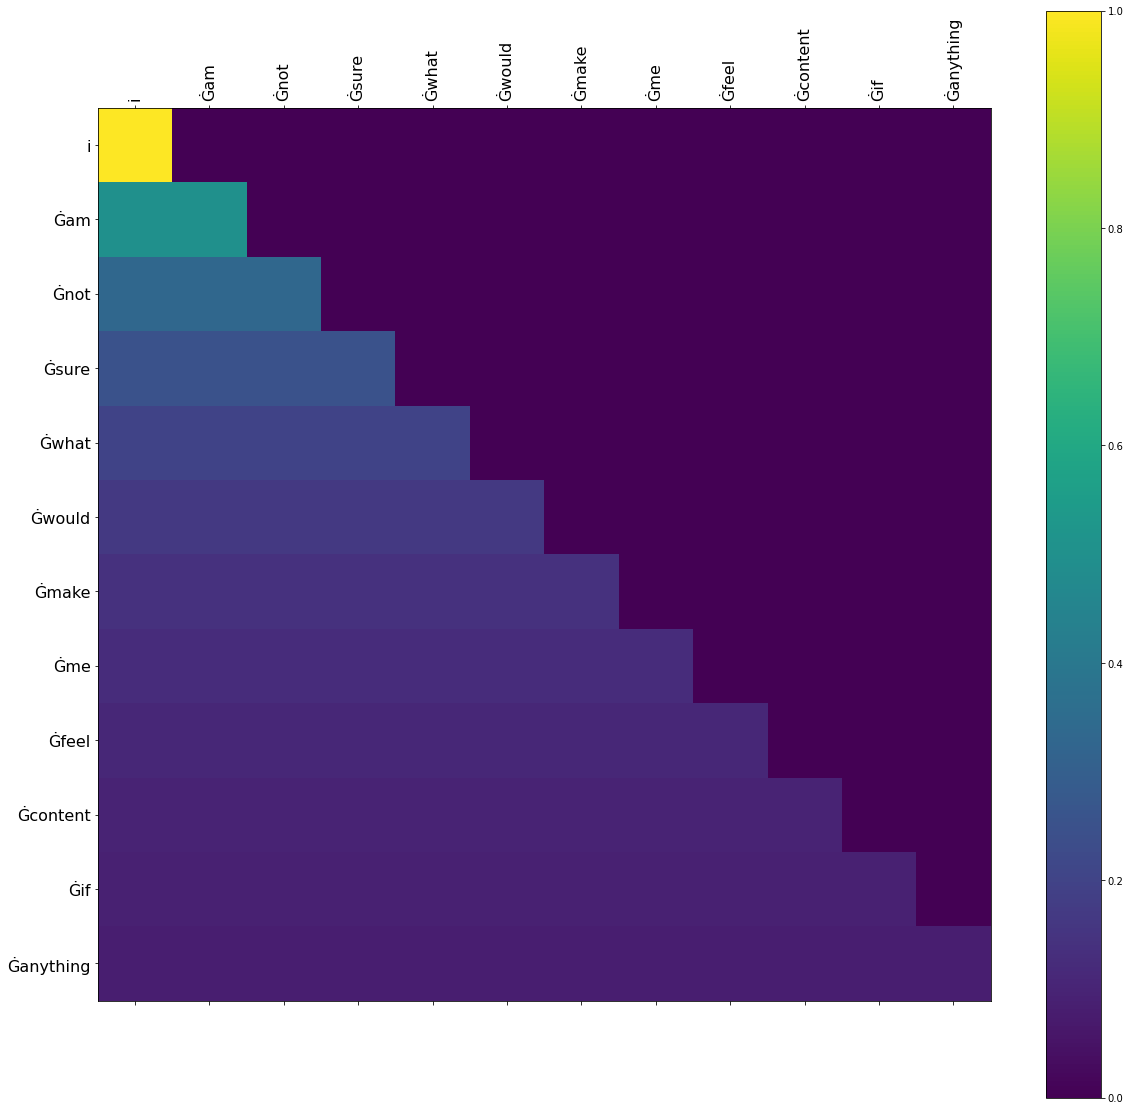

In [49]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [50]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
lr = 3e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [52]:
from tqdm.notebook import tqdm


def accuracy_counter(tensor, target):
    sm = torch.softmax(tensor, dim=1).argmax(dim=1)
    cor = (sm == target)
    acc = cor.sum().float() / float(len(target))
    return acc

num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
        train_loss += criterion(preds[1],target)
        loss = criterion(preds[1],target)
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].squeeze(1).to(device)
            mask  = batch['mask'].squeeze(1).to(device)
            preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
            valid_loss += criterion(preds[1], target)
            valid_acc += accuracy_counter(preds[1],target).item()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
      target = batch['target'].to(device)
      input_ids = batch['input_ids'].squeeze(1).to(device)
      mask  = batch['mask'].squeeze(1).to(device)
      preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
      test_acc += accuracy_counter(preds[1],target).item()
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 0.15779568254947662,Valid Loss: 0.3235596716403961,Valid Acc: 0.892578125



Train Loss: 0.0707523301243782,Valid Loss: 0.3730970323085785,Valid Acc: 0.8994140625



Train Loss: 0.04757409170269966,Valid Loss: 0.4184113144874573,Valid Acc: 0.8974609375



Train Loss: 0.06338825076818466,Valid Loss: 0.4014904201030731,Valid Acc: 0.89697265625



Train Loss: 0.050588253885507584,Valid Loss: 0.4006795883178711,Valid Acc: 0.89794921875



Train Loss: 0.040907952934503555,Valid Loss: 0.4511474370956421,Valid Acc: 0.8916015625



Train Loss: 0.03608987480401993,Valid Loss: 0.3847263753414154,Valid Acc: 0.89990234375



Train Loss: 0.03219248354434967,Valid Loss: 0.42076385021209717,Valid Acc: 0.89794921875



Train Loss: 0.048746462911367416,Valid Loss: 0.45506125688552856,Valid Acc: 0.89501953125



Train Loss: 0.04608342424035072,Valid Loss: 0.46866050362586975,Valid Acc: 0.890625
Test Acc: 0.892578125


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [60]:
text = emotion_dataset['train']['text'][45] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

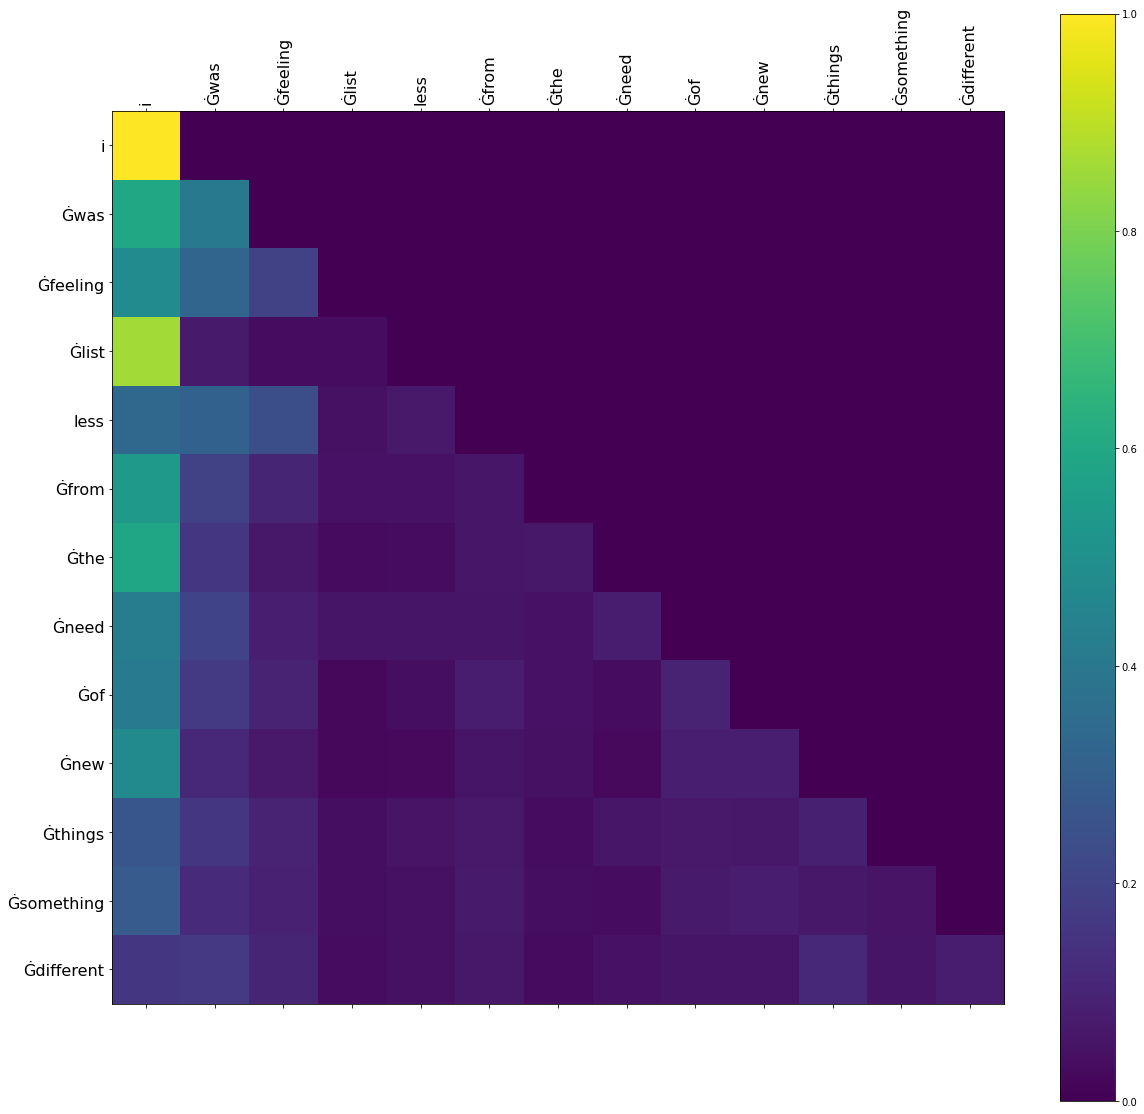

In [61]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

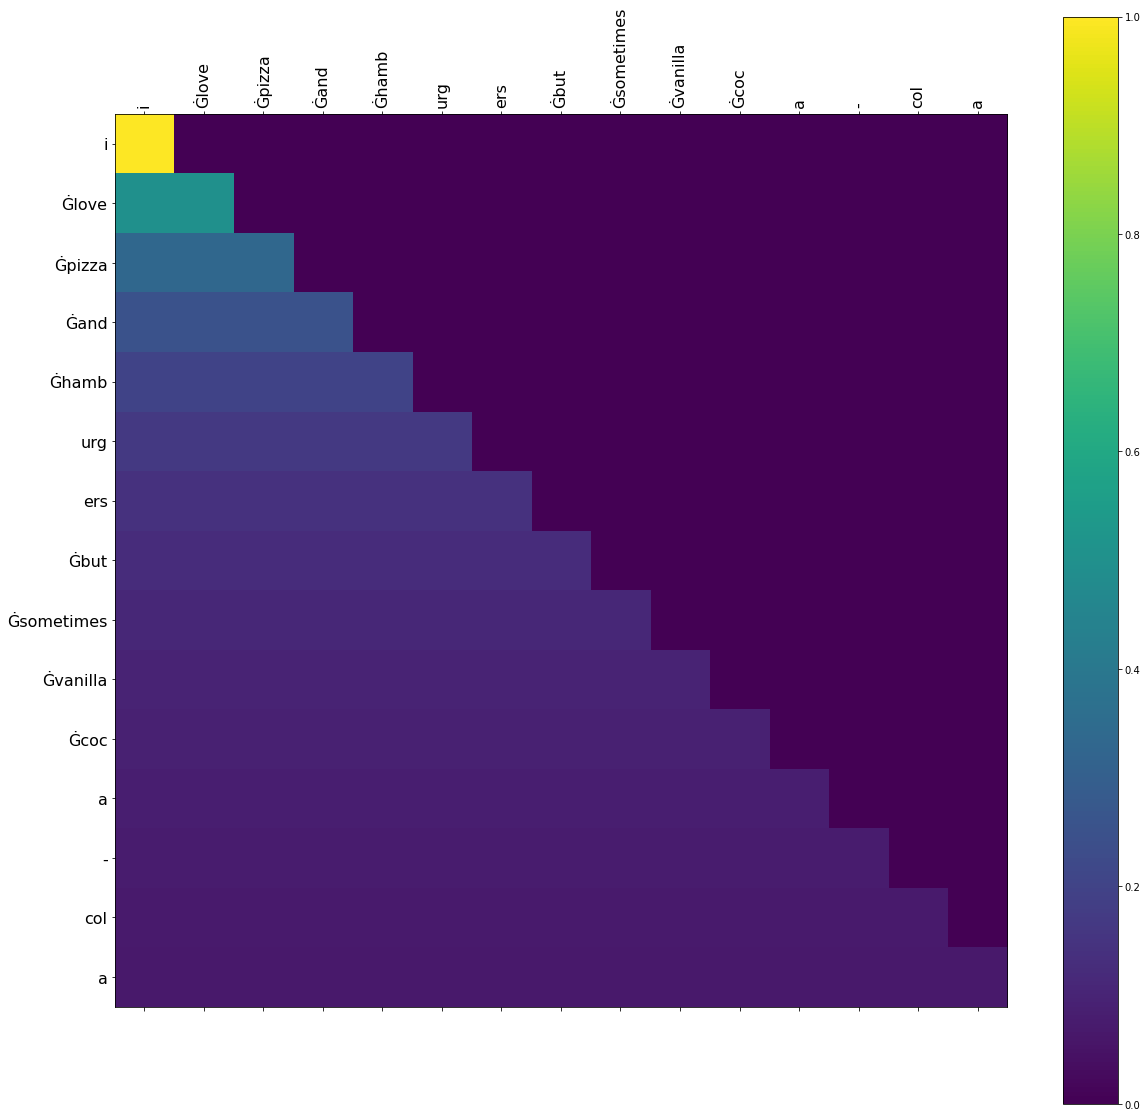

In [62]:
text = 'i love pizza and hamburgers but sometimes vanilla coca-cola' # Выбери текст из датасета
tokens = tokenizer.tokenize(text)
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

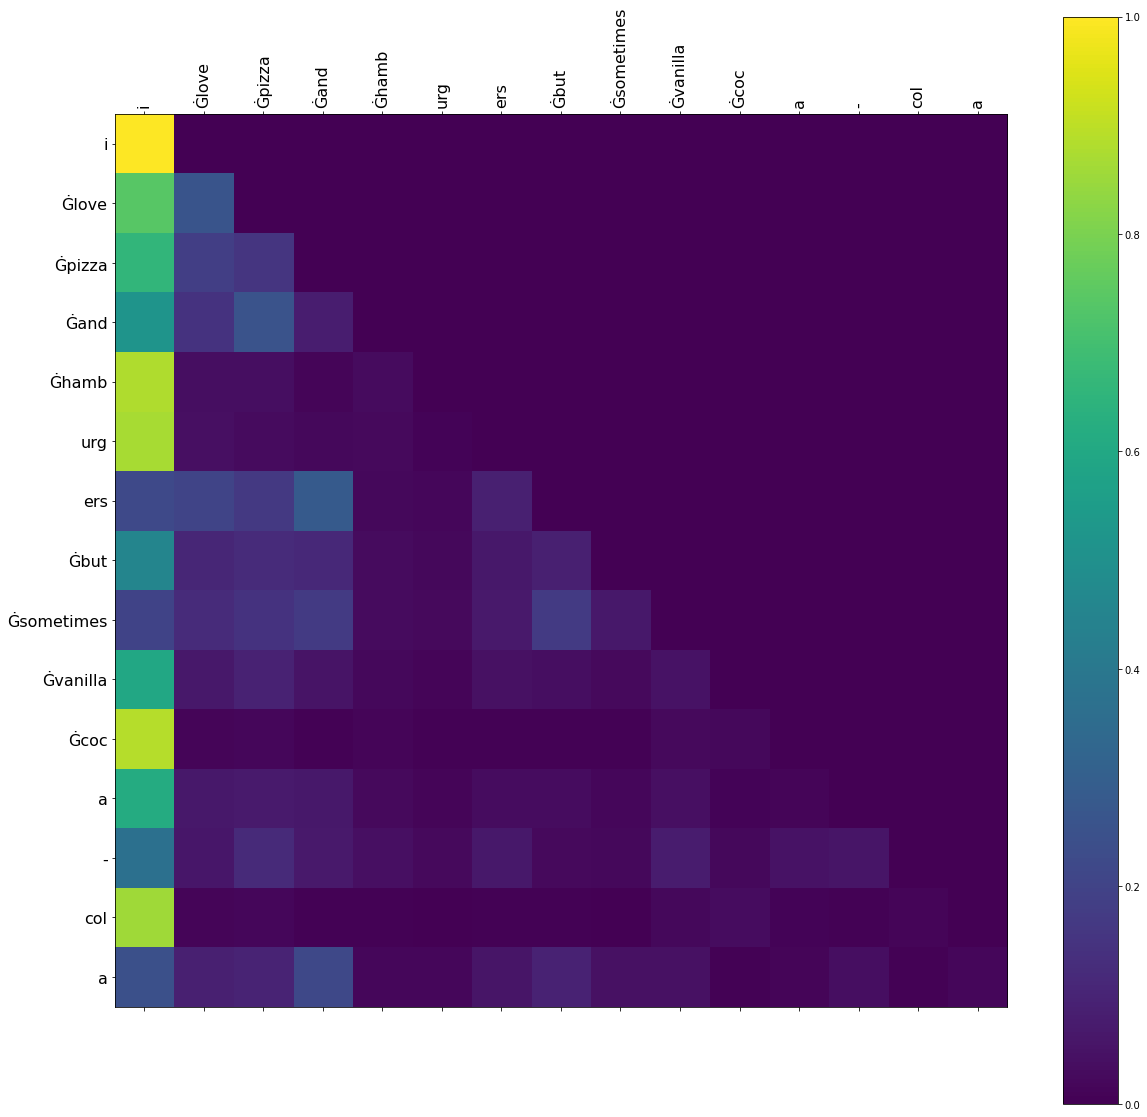

In [63]:
text = 'i love pizza and hamburgers but sometimes vanilla coca-cola' # Выбери текст из датасета
tokens = tokenizer.tokenize(text)
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

Матрица стала лучше на второй моделе. Много атеншена модели обращают на первое слово. Также атеншн пошёл на слово `and` (`и`), что вполне логично, так как мы что-то сравниваем/объединяем в одном контексте. Модель обращает внимание на таких слоях как `it`, `and` и прочие местоимения, т.к. к ним подвязано достаточно много слов, и в них может быть много смысла. 

In [64]:
model_1

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
      